In [3]:
### Import libraries
import torch
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image, to_tensor

import PIL, cv2
from PIL import Image

from io import BytesIO
from IPython.display import display
import base64, json, requests
from matplotlib import pyplot as plt

import numpy as np
import copy

from numpy import asarray

In [4]:
## Import Clip and ClipSeg repositories

# Install Clip from OpenAI ## MIT Licence
! pip install -q git+https://github.com/openai/CLIP.git

# Install ClipSeg Repo ## MIT Licence
! git clone https://github.com/timojl/clipseg


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
Cloning into 'clipseg'...


In [5]:
# %cd clipseg

D:\project\nigga3\clipseg


C:\Users\razor\PycharmProjects\nigga3\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [6]:
# ! wget https://owncloud.gwdg.de/index.php/s/ioHbRzFx6th32hn/download -O weights.zip
# ! unzip -d weights -j weights.zip

--2023-11-30 16:21:31--  https://owncloud.gwdg.de/index.php/s/ioHbRzFx6th32hn/download
Resolving owncloud.gwdg.de (owncloud.gwdg.de)... 134.76.23.45
Connecting to owncloud.gwdg.de (owncloud.gwdg.de)|134.76.23.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: 'weights.zip'

     0K .......... .......... .......... .......... ..........  189K
    50K .......... .......... .......... .......... ..........  189K
   100K .......... .......... .......... .......... .......... 11.6M
   150K .......... .......... .......... .......... ..........  193K
   200K .......... .......... .......... .......... .......... 12.2M
   250K .......... .......... .......... .......... .......... 11.6M
   300K .......... .......... .......... .......... .......... 11.7M
   350K .......... .......... .......... .......... .......... 12.0M
   400K .......... .......... .......... .......... ..........  200K
   450K .......... .......... .......

In [7]:
# Import Clip and ClipSeg model
import clip
from models.clipseg import CLIPDensePredT

# load clipseg model
model = CLIPDensePredT(version='ViT-B/16', reduce_dim=64)
# model.eval();

# non-strict mode: decoder weights only (no CLIP weights)
model.load_state_dict(torch.load('weights/rd64-uni.pth', map_location=torch.device('cuda')), strict=False);

In [8]:
### Import Stable Diffusion model
from diffusers import StableDiffusionInpaintPipeline, EulerDiscreteScheduler

model_dir = "stabilityai/stable-diffusion-2-inpainting"

### The scheduler determine the algorithm used to produce new samples during the denoising process
scheduler = EulerDiscreteScheduler.from_pretrained(model_dir, subfolder="scheduler")

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    model_dir, scheduler=scheduler, revision="fp16", torch_dtype=torch.float16
)
pipe = pipe.to("cuda")
pipe.enable_xformers_memory_efficient_attention()

### if you receive a triton error message, that's normal on windows systems

A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'
C:\Users\razor\PycharmProjects\nigga3\Lib\site-packages\diffusers\pipelines\pipeline_utils.py:263: FutureWarning: You are loading the variant fp16 from stabilityai/stable-diffusion-2-inpainting via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(
unet\diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\razor\PycharmProjects\nigga3\Lib\site-packages\transformers\models\clip\feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


Source image size: (853, 853)
Target image size: (512, 512)


C:\Users\razor\AppData\Local\Temp\ipykernel_7920\2903036915.py:15: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  source_image = source_image.resize((target_width, target_height), Image.LANCZOS )


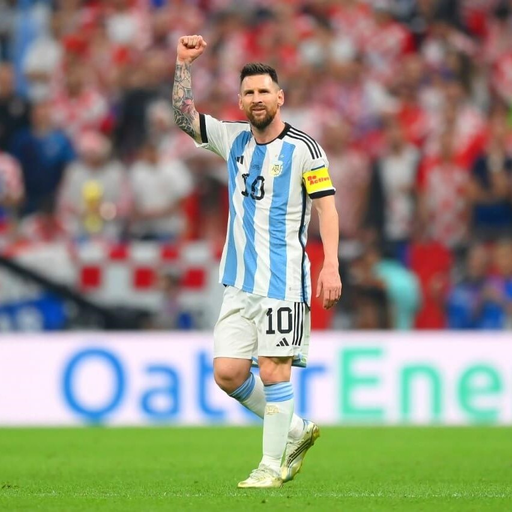

In [9]:
### Example image from unsplash.com

target_width, target_height = 512,512
source_image = Image.open(r"C:\Users\razor\minor_project\istockphoto-676001100-612x612.jpg")

width, height = source_image.size
print(f"Source image size: {source_image.size}")

source_image = source_image.crop((0, height-width , width , height))  # box=(left, upper, right, lower)
source_image = source_image.resize((target_width, target_height), Image.LANCZOS )
print(f"Target image size: {source_image.size}")

### Setup transformations to be applied to the image
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])
tensor_image = transform(source_image).unsqueeze(0)

display(source_image)

In [68]:
#### Create masks for the parts of the clothes to be identified
prompts = ['a yellow band on arm', 'white shorts', 'blue and white stripes shirt', 'tattoo on arm']
# Use ClipSeg to identify elements in picture
with torch.no_grad():
    preds = model(tensor_image.repeat(len(prompts),1,1,1), prompts)[0]

In [11]:
def create_image_grid(original_image, images, names, rows, columns):
    names = copy.copy(names)  # Create a copy of the names list to avoid modifying the external variable
    images = copy.copy(images)  # Create a copy of the images list to avoid modifying the external variable

    if torch.is_tensor(images):
        assert images.size(0) == len(names), "Number of images and names should be equal"
        assert images.size(0) >= (rows * columns) - 1 - 1, "Not enough images for the specified grid size"
        images = [to_pil_image(torch.sigmoid(img)) for img in images]
    else:
        assert len(images) == len(names), "Number of images and names should be equal"
    assert len(images) >= (rows * columns) - 1 - 1, "Not enough images for the specified grid size"
    names.insert(0, '')

    fig, axes = plt.subplots(rows, columns, figsize=(15, 15))

    for idx, (img, name) in enumerate(zip(images, names)):
        row, col = divmod(idx, columns)
        axes[row, col].imshow(img, cmap='gray' if idx > 0 and torch.is_tensor(images) else None)
        axes[row, col].set_title(name)
        axes[row, col].axis('off')

    for idx in range(len(images), rows * columns):
        row, col = divmod(idx, columns)
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

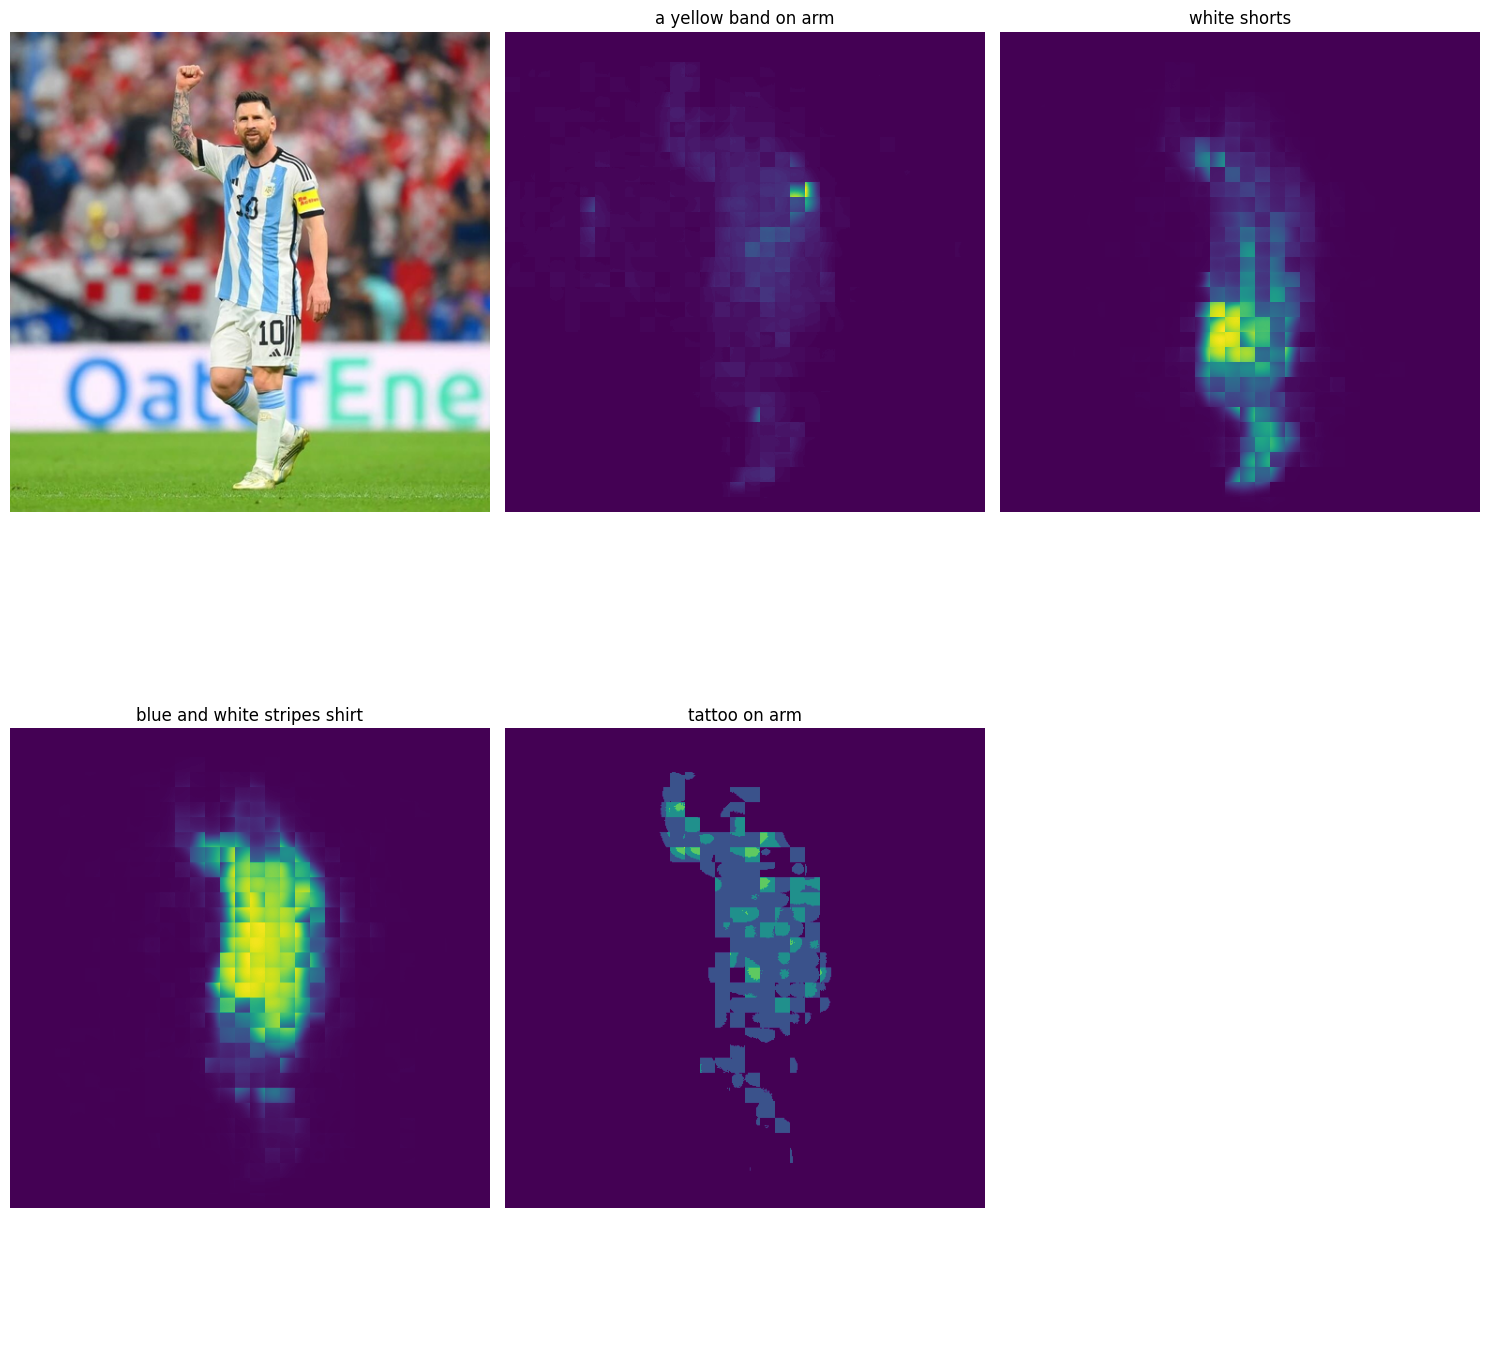

In [69]:
create_image_grid(source_image, preds, prompts, 2, 3)

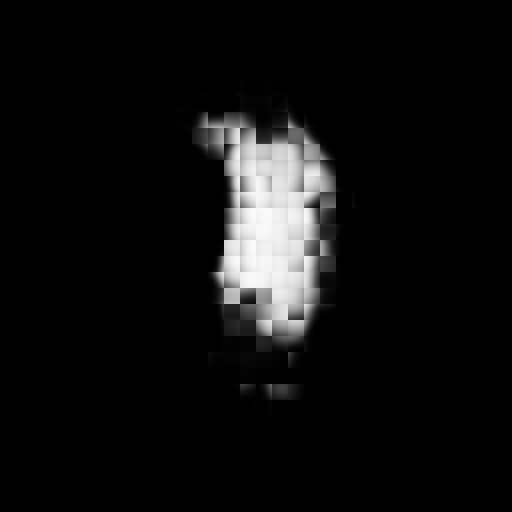

In [70]:
# Decide which mask you want to do inpainting with. In this case we pick the skirt which is mask number 1
mask_number = 2

# Normalize mask values by computing the area under Gaussan probability density function, calculating the cumulative distribution with ndtr
processed_mask = torch.special.ndtr(preds[mask_number][0])
stable_diffusion_mask = transforms.ToPILImage()(processed_mask)
display(stable_diffusion_mask)

In [71]:
### Setup transformation prompts
num_images_per_prompt = 4
inpainting_prompts = ["black lines",  "red blue green", "flowers", "japanese kimono"]
generator = torch.Generator(device="cuda").manual_seed(101) # 155, 77,

### Run Stable Difussion pipeline in inpainting mode
encoded_images = []
for i in range(num_images_per_prompt):
        image = pipe(prompt=inpainting_prompts[i], guidance_scale=7.5, num_inference_steps=60, generator=generator, image=source_image, mask_image=stable_diffusion_mask).images[0]
        encoded_images.append(image)

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

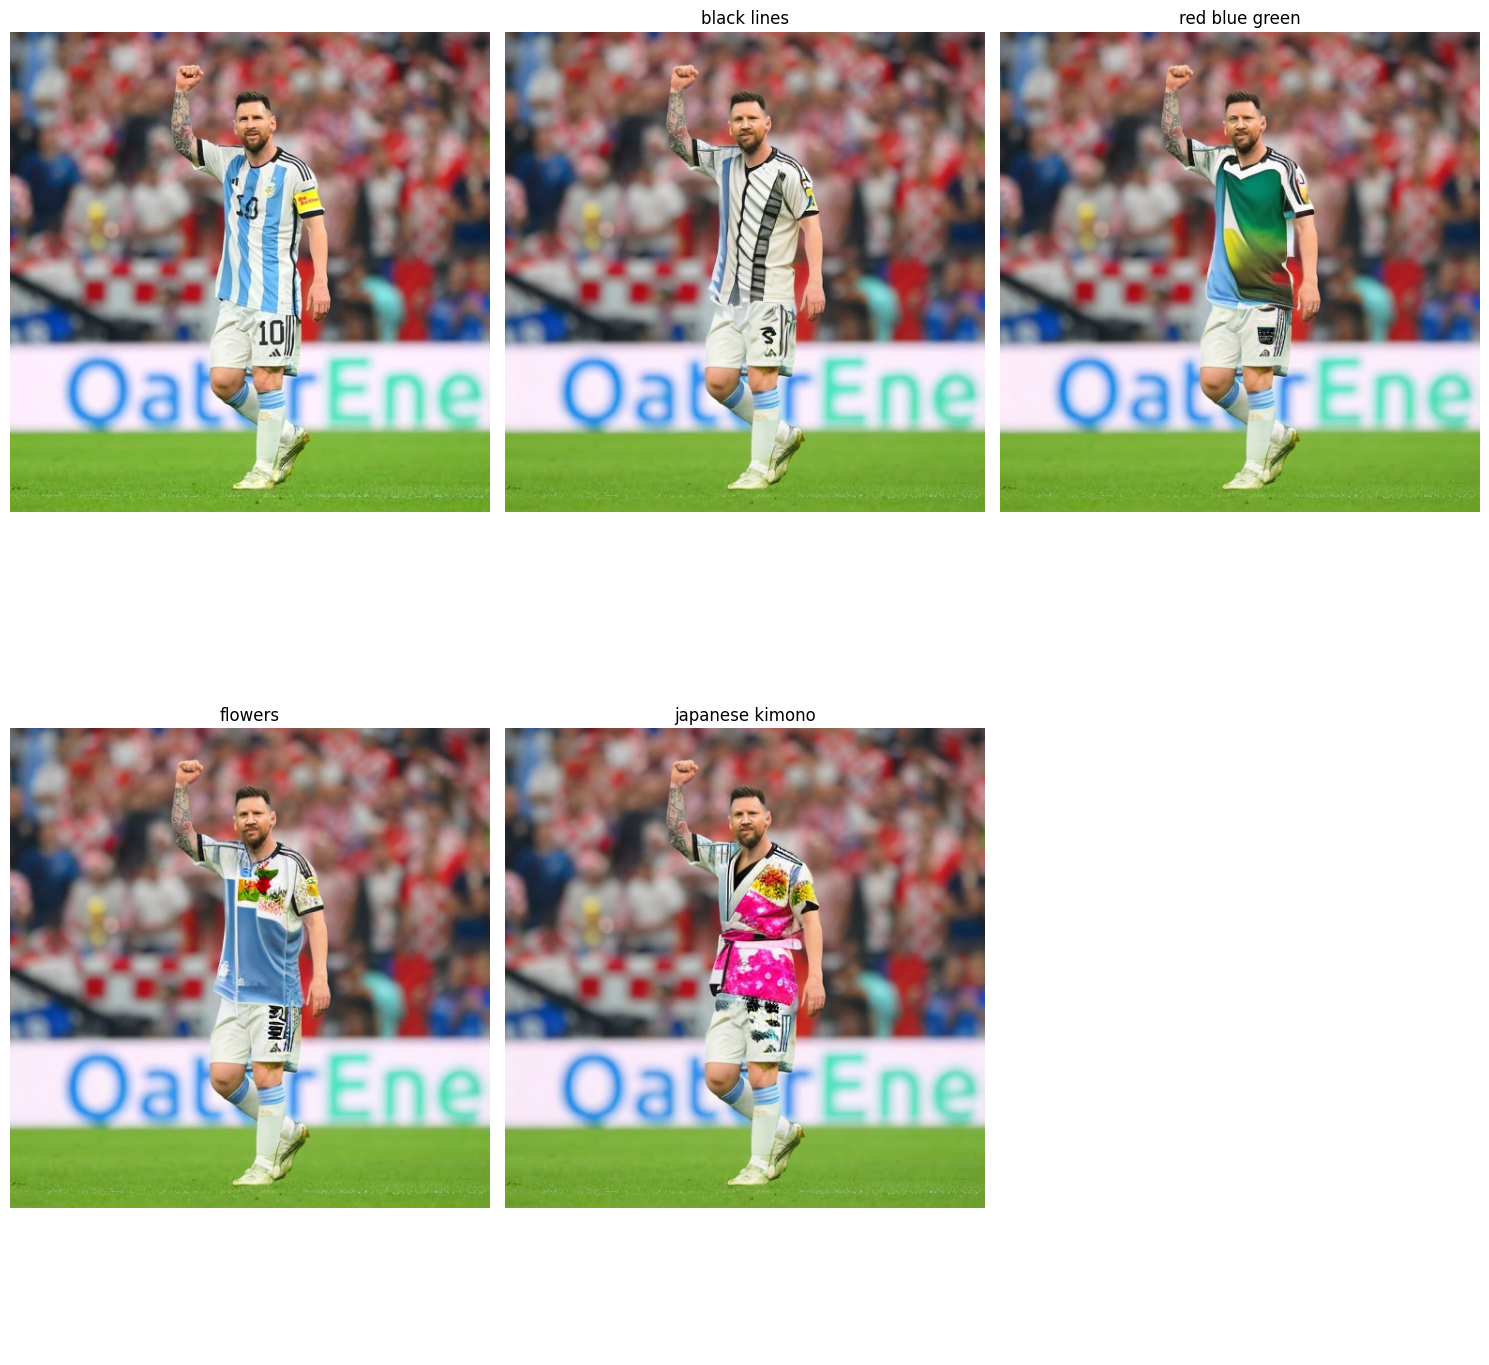

In [72]:
create_image_grid(source_image, encoded_images, inpainting_prompts, 2, 3)